In [5]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing

In [6]:
# transform a timeseries dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
            # put it all together
    agg = pd.concat(cols, axis=1)
        # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [7]:
# load the dataset
path = './IC00.xls'
file = pd.read_excel(path)
values = file.loc[:, 'C_'].values
values = values.reshape(-1,1)
# transform the timeseries data into supervised learning
values.shape

(10848, 1)

In [8]:
# 用来标准
scaler = preprocessing.StandardScaler().fit(values)
values = scaler.transform(values)

In [9]:
train = series_to_supervised(values, n_in=30)
# split into input andoutput columns
trainX, trainy =train[:, :-1], train[:, -1].reshape(-1,1)
trainX.shape,trainy.shape

((10818, 30), (10818, 1))

In [10]:
trainX.shape,trainy.shape

((10818, 30), (10818, 1))

In [11]:
trainX[:5],trainy[:5]

(array([[-1.63174666, -1.57152829, -1.53390518, -1.54605521, -1.56875707,
         -1.56214917, -1.61746475, -1.5999855 , -1.56918351, -1.55820555,
         -1.52409961, -1.54935948, -1.48988706, -1.51248232, -1.54051308,
         -1.51162976, -1.50288997, -1.54232481, -1.54360414, -1.56534651,
         -1.52015632, -1.53315923, -1.52921562, -1.58367832, -1.59625511,
         -1.61373436, -1.61480014, -1.57472563, -1.54147258, -1.54243175],
        [-1.57152829, -1.53390518, -1.54605521, -1.56875707, -1.56214917,
         -1.61746475, -1.5999855 , -1.56918351, -1.55820555, -1.52409961,
         -1.54935948, -1.48988706, -1.51248232, -1.54051308, -1.51162976,
         -1.50288997, -1.54232481, -1.54360414, -1.56534651, -1.52015632,
         -1.53315923, -1.52921562, -1.58367832, -1.59625511, -1.61373436,
         -1.61480014, -1.57472563, -1.54147258, -1.54243175, -1.48146711],
        [-1.53390518, -1.54605521, -1.56875707, -1.56214917, -1.61746475,
         -1.5999855 , -1.56918351, -

#  数据模块

In [12]:
class DiabetesDataset(Dataset):
    def __init__(self, x_, y_):
        self.len = x_.shape[0]
        self.x_data = torch.from_numpy(x_)
        # 这部很关键， 特征类型要求float类型
        self.x_data = self.x_data.float()
        self.y_data = torch.from_numpy(y_)
        self.y_data = self.y_data.float()
        

    def __getitem__(self, item):
        return self.x_data[item], self.y_data[item]

    def __len__(self):
        return self.len

In [13]:
dataset = DiabetesDataset(trainX, trainy)
train_loader = DataLoader(dataset=dataset, batch_size=512, shuffle=False)

# 网络结构

In [14]:
# input_size 输入特征的大小
# hidden_size 神经元模块额数量
# num_layer 几层隐藏层
# lstm默认输入的维度是 (seq_len,batch,feature)
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size = 1,
            hidden_size = 64,
            num_layers = 1,
            batch_first = True
        )
        self.out = nn.Linear(in_features = 64,out_features = 1)
    def forward(self, x):
        output,(h_n,c_n) = self.lstm(x)
        out = self.out(output[:,-1,:])
        return out

In [15]:
device = torch.device('cuda')
model = LSTM().to(device)

# 训练

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
total_step = len(train_loader)
epochs = 100
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1,30,1)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #rint(outputs.shape,labels.shape)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0 :
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.item()))

Epoch [1/100], Step [5/22], Loss: 0.0009
Epoch [1/100], Step [10/22], Loss: 0.0004
Epoch [1/100], Step [15/22], Loss: 0.0009
Epoch [1/100], Step [20/22], Loss: 0.0014
Epoch [2/100], Step [5/22], Loss: 0.0009
Epoch [2/100], Step [10/22], Loss: 0.0005
Epoch [2/100], Step [15/22], Loss: 0.0009
Epoch [2/100], Step [20/22], Loss: 0.0015
Epoch [3/100], Step [5/22], Loss: 0.0009
Epoch [3/100], Step [10/22], Loss: 0.0021
Epoch [3/100], Step [15/22], Loss: 0.0032
Epoch [3/100], Step [20/22], Loss: 0.0016
Epoch [4/100], Step [5/22], Loss: 0.0014
Epoch [4/100], Step [10/22], Loss: 0.0047
Epoch [4/100], Step [15/22], Loss: 0.0010
Epoch [4/100], Step [20/22], Loss: 0.0016
Epoch [5/100], Step [5/22], Loss: 0.0009
Epoch [5/100], Step [10/22], Loss: 0.0043
Epoch [5/100], Step [15/22], Loss: 0.0014
Epoch [5/100], Step [20/22], Loss: 0.0033
Epoch [6/100], Step [5/22], Loss: 0.0011
Epoch [6/100], Step [10/22], Loss: 0.0035
Epoch [6/100], Step [15/22], Loss: 0.0031
Epoch [6/100], Step [20/22], Loss: 0.004

Epoch [49/100], Step [20/22], Loss: 0.0029
Epoch [50/100], Step [5/22], Loss: 0.0008
Epoch [50/100], Step [10/22], Loss: 0.0007
Epoch [50/100], Step [15/22], Loss: 0.0032
Epoch [50/100], Step [20/22], Loss: 0.0028
Epoch [51/100], Step [5/22], Loss: 0.0008
Epoch [51/100], Step [10/22], Loss: 0.0008
Epoch [51/100], Step [15/22], Loss: 0.0028
Epoch [51/100], Step [20/22], Loss: 0.0029
Epoch [52/100], Step [5/22], Loss: 0.0008
Epoch [52/100], Step [10/22], Loss: 0.0007
Epoch [52/100], Step [15/22], Loss: 0.0029
Epoch [52/100], Step [20/22], Loss: 0.0027
Epoch [53/100], Step [5/22], Loss: 0.0009
Epoch [53/100], Step [10/22], Loss: 0.0008
Epoch [53/100], Step [15/22], Loss: 0.0027
Epoch [53/100], Step [20/22], Loss: 0.0026
Epoch [54/100], Step [5/22], Loss: 0.0008
Epoch [54/100], Step [10/22], Loss: 0.0007
Epoch [54/100], Step [15/22], Loss: 0.0025
Epoch [54/100], Step [20/22], Loss: 0.0024
Epoch [55/100], Step [5/22], Loss: 0.0009
Epoch [55/100], Step [10/22], Loss: 0.0009
Epoch [55/100], S

Epoch [97/100], Step [20/22], Loss: 0.0025
Epoch [98/100], Step [5/22], Loss: 0.0008
Epoch [98/100], Step [10/22], Loss: 0.0007
Epoch [98/100], Step [15/22], Loss: 0.0024
Epoch [98/100], Step [20/22], Loss: 0.0022
Epoch [99/100], Step [5/22], Loss: 0.0008
Epoch [99/100], Step [10/22], Loss: 0.0007
Epoch [99/100], Step [15/22], Loss: 0.0021
Epoch [99/100], Step [20/22], Loss: 0.0025
Epoch [100/100], Step [5/22], Loss: 0.0008
Epoch [100/100], Step [10/22], Loss: 0.0007
Epoch [100/100], Step [15/22], Loss: 0.0024
Epoch [100/100], Step [20/22], Loss: 0.0022


# 预测

In [20]:
predicted = model(torch.FloatTensor(trainX.reshape(-1,30,1)).to(device))

In [21]:
predicted.shape,trainy.shape

(torch.Size([10818, 1]), (10818, 1))

In [22]:
import matplotlib.pyplot as plt

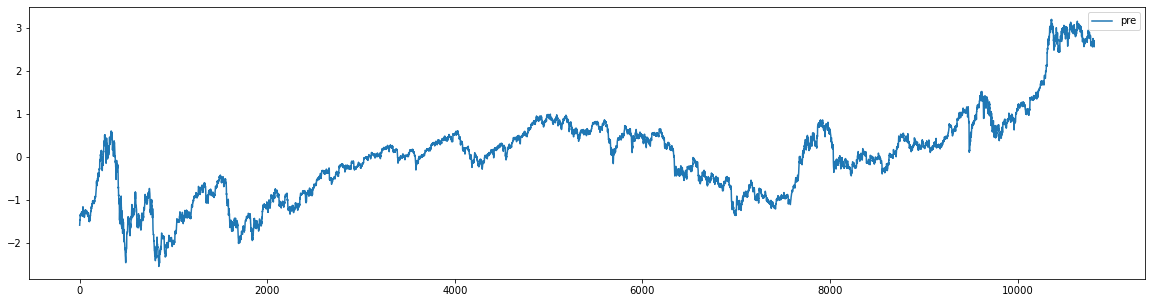

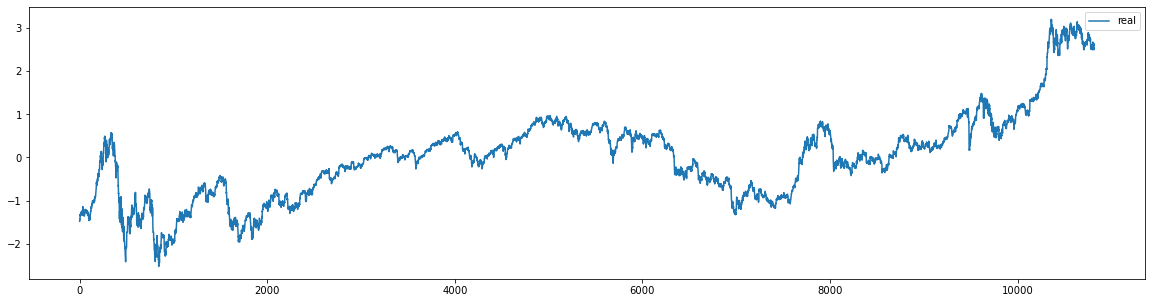

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(predicted.cpu().detach().numpy(),label='pre')
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(20, 5))
plt.plot(trainy,label = 'real')
plt.legend(loc='best')

In [24]:
predicted.cpu().detach().numpy()

array([[-1.5894815],
       [-1.524079 ],
       [-1.502182 ],
       ...,
       [ 2.554876 ],
       [ 2.5541024],
       [ 2.6107347]], dtype=float32)

In [25]:
trainy

array([[-1.48146711],
       [-1.4646272 ],
       [-1.43638321],
       ...,
       [ 2.49552844],
       [ 2.53546838],
       [ 2.52827932]])

# 保存模型

In [26]:
path = './lst_ft.pth'
torch.save(model.state_dict(),path)